## Original: [nicknochnack](https://github.com/nicknochnack/TensorflowKeras-ReinforcementLearning/blob/master/Deep%20Reinforcement%20Learning.ipynb)

### Dependencies

In [1]:
#!pip install tensorflow==2.3.0
#!pip install gym
#!pip install keras
#!pip install keras-rl2

<a href="https://gym.openai.com/">
  <img src="https://gym.openai.com/assets/dist/footer/openai-logo-ce082f60cc.svg" 
  alt="Images" width="200">
</a>
<a href="https://gym.openai.com/">
  <img src="https://gym.openai.com/assets/dist/home/header/home-icon-54c30e2345.svg" 
  alt="Images" width="42">
</a>

> *Gym* ist ein Tool zur Entwicklung und zum Vergleich von **Reinforcement-Learning-Algorithmen**.

#  CartPole-v1

> * [Enviroment](https://gym.openai.com/envs/CartPole-v1/)
> * [GitHub](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py)

<p align="center">
  <img src="CartPole.jpg" alt="drawing" width="420" align="center"/>
</p>

> * A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track.
> * The pendulum starts upright, and the goal is to prevent it from falling over.
> * The system is controlled by applying a force of +1 or -1 to the cart.
> * A reward of +1 is provided for every timestep that the pole remains upright.
> * The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

# Enviroment Setup

        All observations are assigned a uniform random value in [-0.05..0.05]

In [2]:
import gym 
env = gym.make('CartPole-v1')

## Observation

        Num     Observation               Min                     Max
        0       Cart Position             -2.4                    2.4
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.209 rad (-12 deg)    0.209 rad (12 deg)
        3       Pole Angular Velocity     -Inf                    Inf

In [3]:
states = env.observation_space.shape[0]
print(states)

4


## Action

        Num   Action
        0     Push cart to the left
        1     Push cart to the right

In [4]:
actions = env.action_space.n
print(actions)

2


## Reward
        Reward is 1 for every step taken, including the termination step
        
## Done
        Pole Angle is more than 12 degrees.
        Cart Position is more than 2.4 (center of the cart reaches the edge of the display).
        Episode length is greater than 500.
        
        
<a href="https://gym.openai.com/docs/">
  <img src="https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg" 
   alt="Images" width="300">
</a>

## Random Actions
> * `action = random.choice([0,1])` 
> $\rightarrow$ **action** wird über  `env.step(action)` an **Enviroment** übergeben.


> * `new_state, reward, done, info = env.step(action)`

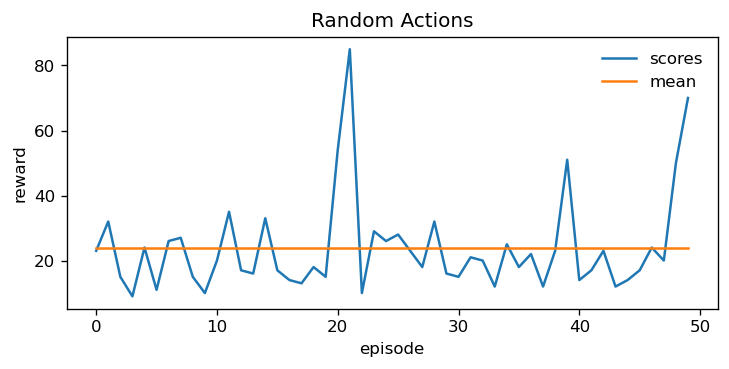

In [5]:
import time
time.sleep(1)

import random
from numpy import mean
import matplotlib.pyplot as plt

episodes = 50
scores = []

for episode in range(1, episodes+1):
    
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        env.render()
        action = random.choice([0,1])
        new_state, reward, done, info = env.step(action)
        score += reward
    scores.append(score)
env.close()

mean_reward = mean(scores)
fig, (ax1) = plt.subplots(1,1, figsize=(7,3),dpi=120)
ax1.plot(scores, label=r'scores')
ax1.plot([0,episodes-1],[mean_reward,mean_reward], label=r'mean')
ax1.set_title('Random Actions')
ax1.set_xlabel('episode')  
ax1.set_ylabel('reward')  
ax1.legend(loc=('best'), frameon=False, fontsize=10)
#plt.savefig("randomActions.png")

# Reinforcement Learing Roadmap

> * Create a Deep Neural Network
> * Define the Agent's Memory and Policy
> * Build DQN-Agent
> * Train DQN-Agent

## 1. Create a Deep Neural Network

<a href="https://keon.github.io/deep-q-learning/">
  <img src="https://keon.github.io/images/deep-q-learning/neuralnet.png" 
alt="Images" width="300">
</a>

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1,states)))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

model = build_model(states, actions)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4)                 0         
_________________________________________________________________
dense (Dense)                (None, 24)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________


## 2. Define the Agent's Memory and Policy

### Memory
> * Datenstruktur, welche die **Erfahrungen** des Agenten speichert.
> * Erfahrungen bestehen aus **`state, action, reward `** und **`next_state`**
> * Speicherkapazität stellt *Hyperparamter* dar. Wenn die Kapazität erreicht ist, werden alte Erfahrungen überschrieben. 

### Policy
> * Die *innere Politik* des Agenten beschreibt die Balance zwischen *Erforschung* und *Verwertung*. 
> * Boltzmann Q Policy erstellt ein Wahrscheinlichkeitsgesetz auf q-Werten und gibt eine zufällig nach diesem Gesetz ausgewählte Aktion zurück.    
Beim Erkunden erstellt der Agent eine Aktionsverteilung. Diese Verteilung beschreibt, wie optimal eine Aktion gemäß den vom Agenten gesammelten Daten ist. Wenn Sie wollen, können Sie sagen, dass die Aktionsverteilung die Überzeugung des Agenten über die optimale Aktion beschreibt.

Bei der Boltzmann-Policy-Implementierung wird die ursprüngliche Aktionsverteilung durch den Temperaturparameter dividiert. Aus diesem Grund verwandelt die Boltzmann-Policy das Erkundungsverhalten des Agenten in ein Spektrum zwischen der zufälligen Auswahl der Aktion (Random-Policy) und der immer optimalen Auswahl (Greedy-Policy).
   

## 3. Build DQN-Agent

### Agent
> * With a model, memory, and policy defined, we’re now ready to create a deep Q network Agent and send that agent those objects. 
> * Each agent interacts with the environment (as defined by the Env class) by first observing the state of the environment. Based on this observation the agent changes the environment by performing an action.
**Agend** entscheidet sich aufgrund seiner *inneren Politik* für eine Aktion.


#### Q-Learining

> Q-learning (which doesn’t stand for anything, by the way) is centered around creating a “virtual table” that accounts for how much reward is assigned to each possible action given the current state of the environment.

You can imagine the DQN network as internally maintaining a spreadsheet of the values of each of the possible actions that can be taken given the current environment state

Deep Q-Learning
As an agent takes actions and moves through an environment, it learns to map the observed state of the environment to an action. An agent will choose an action in a given state based on a "Q-value", which is a weighted reward based on the expected highest long-term reward. A Q-Learning Agent learns to perform its task such that the recommended action maximizes the potential future rewards. This method is considered an "Off-Policy" method, meaning its Q values are updated assuming that the best action was chosen, even if the best action was not chosen.

## Build  DQN-Agent

In [7]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=50, target_model_update=1e-2)
    return dqn

#del model
model = build_model(states, actions)

dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

## Train Agent

In [8]:
startTime = time.time()

episodes = 50000
history = dqn.fit(env, nb_steps=episodes, visualize=False, verbose=1)

print('Training duration: ' + str(round(time.time() - startTime,2)) + 's')
#print(history.params)
#print(history.history.keys())

Training for 50000 steps ...
Interval 1 (0 steps performed)
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
10000/10000 [==============================] - 32s 3ms/step - reward: 1.0000
119 episodes - episode_reward: 83.529 [9.000, 365.000] - loss: 1.865 - mae: 18.996 - mean_q: 38.584

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 31s 3ms/step - reward: 1.0000
48 episodes - episode_reward: 207.604 [153.000, 339.000] - loss: 4.014 - mae: 37.370 - mean_q: 75.363

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 31s 3ms/step - reward: 1.0000
54 episodes - episode_reward: 186.352 [144.000, 278.000] - loss: 3.572 - mae: 42.686 - mean_q: 86.188

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 34s 3ms/step - reward: 1.0000
60 episodes - episode_reward: 164.867 [143.000, 188.000] - loss: 1.818 - mae: 45.989 - mean_q: 92.998



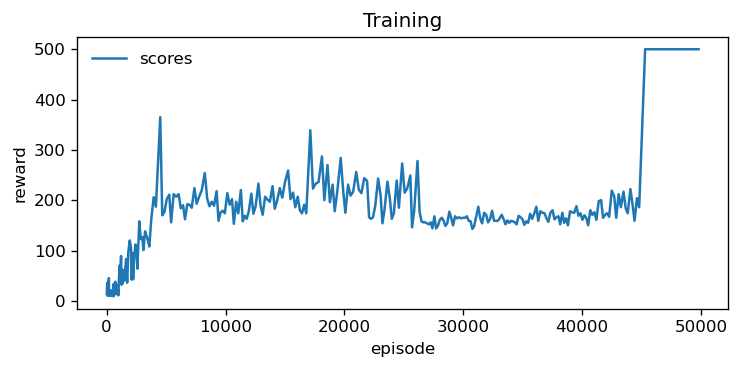

In [9]:
fig, (ax1) = plt.subplots(1,1, figsize=(7,3),dpi=120)
ax1.plot(history.history['nb_steps'], history.history['episode_reward'], label=r'scores')
ax1.set_title('Training')
ax1.set_xlabel('episode')  
ax1.set_ylabel('reward')  
ax1.legend(loc=('best'), frameon=False, fontsize=10)
plt.savefig("Training.png")

## Test Agent

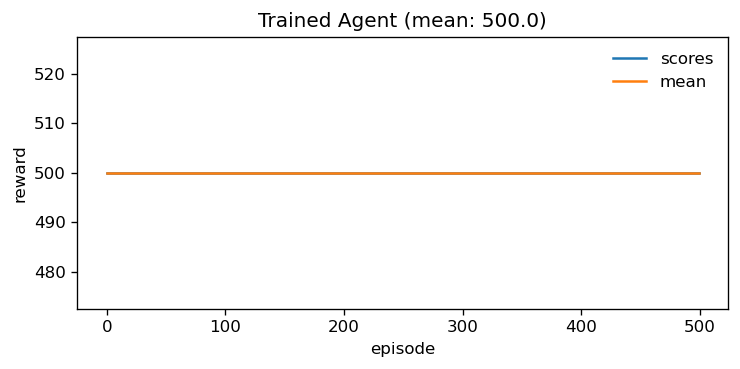

In [10]:
episodes = 500
scores = dqn.test(env, nb_episodes=episodes, visualize=False, verbose=0)

mean_reward = mean(scores.history['episode_reward'])
fig, (ax1) = plt.subplots(1,1, figsize=(7,3),dpi=120)
ax1.plot(scores.history['episode_reward'], label=r'scores')
ax1.plot([0,episodes-1],[mean_reward,mean_reward], label=r'mean')
ax1.set_title(f'Trained Agent (mean: {round(mean_reward,2)})')
ax1.set_xlabel('episode')
ax1.set_ylabel('reward')
ax1.legend(loc=('best'), frameon=False, fontsize=10)
plt.savefig("TrainedAgent.png")

In [11]:
time.sleep(1)
_ = dqn.test(env, nb_episodes=5, visualize=True, verbose=1)
env.close()

Testing for 5 episodes ...
Episode 1: reward: 500.000, steps: 500
Episode 2: reward: 500.000, steps: 500
Episode 3: reward: 500.000, steps: 500
Episode 4: reward: 500.000, steps: 500
Episode 5: reward: 500.000, steps: 500
